# Baseball in the Neighborhood

It it entirely self evident that the best neighborhood in Pittsburgh is that which most easily facilitates the age-old sport of baseball. As such, we will analyze the neighborhoods of Pittsburgh using the field listings database for the city.

### How the rating is measured

In order for this metric to most easily combined with other metrics, the metric will range from 0-100. To achieve this, once the raw scores are found, the scores will be changed proportionally so that the lowest score is 0 and the highest score is 100. Neighborhoods without baseball fields are given a 0. The most important factor in this metric is that everyone in the neighborhood can attend a baseball game on any given day. Concretely, the rating of a neighborhood is directly dependent on the percentage of people able to be acommodated by the baseball fields in one day. We will also weigh the capacity of the neighborhood to attend baseball games much greater than other factors. 

Assuming a game takes 3 hours, there can be 4 games from 10-10 in one day. During regular season baseball from March to November, sunset time ranges from 6:15 to 7:45. We will assume that the average sunset time lies at 7pm, leaving an average of around 2.5 hrs of darkness (assuming twilight is playable) where baseball can't be played in unlit fields. Out of the 12 hours of potential playing time, lit fields can accomodate one more game than the rest, which will be accounted in the daily accomodation.
Thus, the formula is of the form:
```
rating = 100 * (.8 * percent_accomodated_daily) * (.2 * satisfaction)
```

According to [NPR](https://www.npr.org/2021/11/09/1053828800/south-korea-seoul-halloween-crowd-safety-tips), maximum safe density is around 5 people/meter^2. For this metric, we'll assume that if you are more than 2 meters behind the front of the crowd, watching the baseball game becomes too difficult to be worthwhile. Let's also assume that people will only line up as far as right and left field extend to, and won't crowd home run territory. Thus, the maximum capacity of the baseball field is calculated as:
```
(right+left)*2*5
```
Were the right and left field are mesured in meters, 2 is the visibilty constant and 5 is the mosh-pit density.

Now this begs the question "how is satisfaction measured?" While capacity is the most important issue, the availability of concession stands is also greatly important. We will assume that the average concession stand takes in two orders at a time, at a speed of 45 seconds per order, for an efficiency of 2.7 orders/min. Ideally, the concession stand effiency will at least match the demand for concession. We will assume that in the 5 minnutes between innings, around 5% of attendees will want a tasty snack. In this way, concession stand optimization will be calculated as:
```
min(2.7*5*stands/capacity*.05, 1)
```

Where 2 is the concessions constant and 5 is the amount of minutes between innings. 

All in all, the metric can be derived like so:
```
capacity_per_game = (right+left)*2*5
capacity_per_day = capacity_per_game * (3 + hasLights) # hasLights is 0 or 1
neighborhood_daily_capacity = summation(capacity_per_day)
percent_accomodated_daily = neighborhood_daily_capacity / neighborhood_population

satisfaction = summation(2.7*5*stands/(capacity*.05), 1)

rating = 100 * (.8 * percent_accomodated daily) + (.2 * satisfaction)
```

### Basic Information

In [1]:
import pandas as pd
import numpy as np
fields = pd.read_csv("fields-Copy1.csv")
# From here: https://data.wprdc.org/dataset/2020-census-redistricting-data-extracts/resource/a8414ed5-c50f-417e-bb67-82b734660da6
hoods = pd.read_csv("neighborhoods.csv")
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
fieldNums = {}
lotsOfFields = []

mostFields = 0

for index, row in fields.iterrows():
    if row['Neighborhood'] in fieldNums:
        fieldNums[row['Neighborhood']] += 1
        if fieldNums[row['Neighborhood']] > mostFields:
            mostFields = fieldNums[row['Neighborhood']]
            lotsOfFields.clear()
            lotsOfFields.append(row['Neighborhood'])
        elif fieldNums[row['Neighborhood']] == mostFields:
            lotsOfFields.append(row['Neighborhood'])
    else:
        fieldNums[row['Neighborhood']] = 1
       
print("The neighborhoods with the most fields, at a grand total of " + str(mostFields) + " are " + str(lotsOfFields) + ".")
print("Out of the 90 neighborhoods in Pittsburgh, " + str(len(fieldNums)) + " have one field or more.") # Num of neighborhoods
print("That's only " + str(round(len(fieldNums)/90*100, 0)) + "%!")

The neighborhoods with the most fields, at a grand total of 7 are ['Brighton Heights', 'Squirrel Hill South'].
Out of the 90 neighborhoods in Pittsburgh, 54 have one field or more.
That's only 60.0%!


### Looks like only 60% of neighborhoods are conducive to America's favorite pastime :(

For those neighborhoods that do have baseball fields, let's examine their distribution.

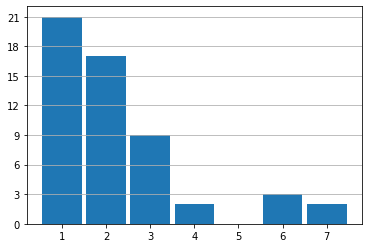

In [3]:
# First two lines from here
# https://stackoverflow.com/questions/37266341/plotting-a-python-dict-in-order-of-key-values

lists = sorted(fieldNums.items())
x, y = zip(*lists)

# Alignment code from here: https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram
plt.hist(y, bins=np.arange(8)+0.5, rwidth = .9)
plt.yticks(np.arange(0, 22, 3))
plt.grid(axis = 'y')
plt.show()

In [4]:
import statistics

numFieldsList = sorted(fieldNums.values())

median = statistics.median(numFieldsList)
mean = statistics.mean(numFieldsList)

print("The mean and median of the number of fields in fielded neighborhoods are " + str(round(mean,2)) + " and " + str(int(median)) + " respectively.")

# Adding empty neighborhoods
for i in range(90-54):
    numFieldsList.append(0)
    
median = statistics.median(numFieldsList)
mean = statistics.mean(numFieldsList)
    
print("The mean and median of the number of fields in ALL neighborhoods are " + str(round(mean,2)) + " and " + str(int(median)) + " respectively.")

The mean and median of the number of fields in fielded neighborhoods are 2.26 and 2 respectively.
The mean and median of the number of fields in ALL neighborhoods are 1.36 and 1 respectively.


Now, let's go ahead and find every neighborhoods capacity.

In [5]:
# Make a dict where the key is the name of the neighborhood and the value is the total capacity per day
# I.e. Loop through fields, add the capacity per day to the neighborhood dict

import re

dayCap = {}

# This dict will have every field (not neighborhood) and have its capacity per day
fieldCap = {}

for index, row in fields.iterrows():
    # Determines daily capacity
    if (not(pd.isna(row['Left']) or pd.isna(row['Right']))):
        
        # This from here: https://bobbyhadz.com/blog/python-remove-all-non-numeric-characters-from-string
        left = re.sub("[^0-9|.]", "", str(row['Left']))
        right = re.sub("[^0-9|.]", "", str(row['Right']))
        
    else:
        # Default values are set to minimums of left and right lengths, calculated in 'DanielDraft'
        left = 148
        right = 100
        
    # Determines presence of lights
    lights = 1 if row['Lights'] == 1 else 0

    # Calculates daily capacity
    capacityPerGame = (int(left) + int(right)) * 10
    capacityPerDay = capacityPerGame * (3 + lights)
        
    # Adds to dayCap
    if row['Neighborhood'] in dayCap:
        dayCap[row['Neighborhood']] += capacityPerDay
    else:
        dayCap[row['Neighborhood']] = capacityPerDay
        
    # Adds to fieldCap
    if row['Field Name'] in fieldCap:
        fieldCap[row['Field Name']] += capacityPerGame
    else:
        fieldCap[row['Field Name']] = capacityPerGame

print(dayCap)
print('\n\n\n')
print(fieldCap)

{'Bedford Dwellings': 45000, 'Southside Slopes': 78970, 'Southside Flates': 10530, 'Lower Lawrenceville': 47220, 'Bankville': 32800, 'Allentown': 7440, 'Squirrel Hill South': 88550, 'Brighton Heights': 102090, 'Broadhead Manor': 7440, 'Brookline': 81980, 'Hazelwood': 64840, 'Overbrook': 7440, 'Lincoln-Lemington-Belmar': 28760, 'Windgap': 53200, 'Troy Hill': 52840, 'South Oakland': 9920, 'Bloomfield': 22080, 'Arlington': 16350, 'Mount Washington': 83040, 'Stanton Heights': 30090, 'Crafton Heights': 38920, 'East Hills': 22920, 'East Liberty': 7440, 'Hihgland Park': 12030, 'Upper Lawrenceville': 10770, 'Fineview': 20040, 'Garfield': 41920, 'Greenfield': 54900, 'Perry South': 40390, 'Elliott': 41680, 'Morningside': 95130, 'Marshall-Shadeland': 34250, 'Beechview': 36800, 'Central Lawrenceville': 51920, 'Terrace Village': 40220, 'Larimer': 9600, 'Beltzhoover': 47810, 'Allegheny Center': 29280, 'Manchester': 34040, 'Lincoln Place': 14340, 'Sheraden': 47910, 'Shadyside': 49350, 'Spring Garden'

In [6]:
POP = 300431

for index, row in hoods.iterrows():
    if row['Neighborhood'] in dayCap:
        dayCap[row['Neighborhood']] = round(dayCap[row['Neighborhood']]/row['2020_Total_Population'],3)
        
# Manual data fixing:
dayCap['Southside Slopes'] = round(dayCap['Southside Slopes']/hoods.loc[72,'2020_Total_Population'],3)
dayCap['Broadhead Manor'] = round(dayCap['Broadhead Manor']/hoods.loc[31,'2020_Total_Population'],3)
dayCap['Bankville'] = round(dayCap['Bankville']/hoods.loc[5,'2020_Total_Population'],3)
dayCap['Arlington'] = round(dayCap['Arlington']/hoods.loc[4,'2020_Total_Population'],3)
dayCap['Hihgland Park'] = round(dayCap['Hihgland Park']/hoods.loc[39,'2020_Total_Population'],3)
dayCap['Mt. Oliver Neigborhood'] = round(dayCap['Mt. Oliver Neigborhood']/hoods.loc[53,'2020_Total_Population'],3)
dayCap['Spring Hill-City View'] = round(dayCap['Spring Hill-City View']/hoods.loc[74,'2020_Total_Population'],3)
dayCap['Southside Flats'] = round((dayCap['Southside Flats']+dayCap['Southside Flates'])/hoods.loc[71,'2020_Total_Population'],3)
del dayCap['Southside Flates']

print(dayCap)

{'Bedford Dwellings': 32.468, 'Southside Slopes': 100.471, 'Lower Lawrenceville': 17.88, 'Bankville': 23.665, 'Allentown': 3.228, 'Squirrel Hill South': 5.781, 'Brighton Heights': 14.369, 'Broadhead Manor': 6.526, 'Brookline': 6.276, 'Hazelwood': 16.673, 'Overbrook': 2.136, 'Lincoln-Lemington-Belmar': 7.91, 'Windgap': 39.583, 'Troy Hill': 19.977, 'South Oakland': 2.98, 'Bloomfield': 2.548, 'Arlington': 3.962, 'Mount Washington': 9.534, 'Stanton Heights': 6.797, 'Crafton Heights': 9.732, 'East Hills': 7.925, 'East Liberty': 1.203, 'Hihgland Park': 4.597, 'Upper Lawrenceville': 4.499, 'Fineview': 17.579, 'Garfield': 11.507, 'Greenfield': 7.561, 'Perry South': 10.728, 'Elliott': 19.006, 'Morningside': 29.253, 'Marshall-Shadeland': 8.465, 'Beechview': 4.845, 'Central Lawrenceville': 11.0, 'Terrace Village': 17.336, 'Larimer': 6.214, 'Beltzhoover': 29.807, 'Allegheny Center': 20.634, 'Manchester': 16.76, 'Lincoln Place': 4.545, 'Sheraden': 9.308, 'Shadyside': 3.222, 'Spring Garden': 12.634,

Great, now all that's left is to find the satisfaction index.

In [7]:
# Lets first make a dictionary that maps the neighborhoods to the concession stands

satisfaction = {}

for index, row in fields.iterrows():
    stand = 0
    if (not(pd.isna(row['Concession Stand']))):
        stand = row['Concession Stand']
        
    else:
        stand = 0
        
    if row['Neighborhood'] in satisfaction:
        # This has to be average not simple sum
        satisfaction[row['Neighborhood']] += (13.5*stand)/(fieldCap[row['Field Name']]*.05)
    else:
        satisfaction[row['Neighborhood']] = (13.5*stand)/(fieldCap[row['Field Name']]*.05)
      
# Making it average
for key in satisfaction:
    satisfaction[key] /= fieldNums[key]
    
print(satisfaction)
        
    

{'Bedford Dwellings': 0.0, 'Southside Slopes': 0.06629032258064516, 'Southside Flates': 0.0, 'Lower Lawrenceville': 0.016216216216216217, 'Bankville': 0.03648648648648649, 'Allentown': 0.0, 'Squirrel Hill South': 0.07627030087604789, 'Brighton Heights': 0.04480118093956579, 'Broadhead Manor': 0.0, 'Brookline': 0.1363251615935091, 'Hazelwood': 0.031135823894775302, 'Overbrook': 0.0, 'Lincoln-Lemington-Belmar': 0.05443548387096774, 'Windgap': 0.0406015037593985, 'Troy Hill': 0.044382574516868646, 'South Oakland': 0.0, 'Bloomfield': 0.04891304347826087, 'Arlington': 0.0, 'Mount Washington': 0.03746487847568746, 'Stanton Heights': 0.055998759305210914, 'Crafton Heights': 0.09144856968959221, 'East Hills': 0.0, 'East Liberty': 0.0, 'Hihgland Park': 0.0, 'Upper Lawrenceville': 0.0, 'Fineview': 0.0, 'Garfield': 0.052604377749106715, 'Greenfield': 0.031172780270134107, 'Perry South': 0.0, 'Elliott': 0.057294721407624635, 'Morningside': 0.06897583493551916, 'Marshall-Shadeland': 0.0310344827586

So, for every neighborhood, we have satisfaction and its daily capacity.

In [8]:
ratings = {}
keys = []
bestRate = 0

for key in dayCap:
    if key in satisfaction:
        ratings[key] = 100 * ((.8*dayCap[key]) + (.2*satisfaction[key]))
        
    if ratings[key] > bestRate:
        bestHood = key
        bestRate = ratings[key]
        
print(ratings)
print("\n\nThe best neighborhood for baseball is " + str(bestHood) + "!")


{'Bedford Dwellings': 2597.4400000000005, 'Southside Slopes': 8039.005806451612, 'Lower Lawrenceville': 1430.7243243243245, 'Bankville': 1893.9297297297294, 'Allentown': 258.24, 'Squirrel Hill South': 464.0054060175209, 'Brighton Heights': 1150.4160236187913, 'Broadhead Manor': 522.08, 'Brookline': 504.80650323187024, 'Hazelwood': 1334.4627164778956, 'Overbrook': 170.88, 'Lincoln-Lemington-Belmar': 633.8887096774193, 'Windgap': 3167.452030075188, 'Troy Hill': 1599.0476514903373, 'South Oakland': 238.39999999999998, 'Bloomfield': 204.81826086956522, 'Arlington': 316.96000000000004, 'Mount Washington': 763.4692975695139, 'Stanton Heights': 544.8799751861042, 'Crafton Heights': 780.3889713937918, 'East Hills': 634.0, 'East Liberty': 96.24000000000001, 'Hihgland Park': 367.76000000000005, 'Upper Lawrenceville': 359.91999999999996, 'Fineview': 1406.3200000000002, 'Garfield': 921.6120875549822, 'Greenfield': 605.5034556054027, 'Perry South': 858.24, 'Elliott': 1521.6258944281526, 'Morningsid

In [9]:
scores = [(k, v) for k, v in ratings.items()]
# Sorting tuple list from here https://www.geeksforgeeks.org/python-program-to-sort-a-list-of-tuples-by-second-item/
scores.sort(key = lambda x: x[1], reverse = True)

print("And now the moment you've all been waiting for: \n")

for hood in scores: 
    print(hood[0] + ": " + str(round(100*hood[1]/bestRate, 2)) + "%")

%store scores
%store bestRate

And now the moment you've all been waiting for: 

Southside Slopes: 100.0%
West End: 68.74%
Polish Hill: 39.54%
Windgap: 39.4%
Bedford Dwellings: 32.31%
Beltzhoover: 29.67%
Morningside: 29.13%
Mt. Oliver Neigborhood: 26.05%
Bankville: 23.56%
Allegheny Center: 20.53%
Troy Hill: 19.89%
Elliott: 18.93%
Homewood South: 18.11%
Lower Lawrenceville: 17.8%
Fineview: 17.49%
Terrace Village: 17.27%
Manchester: 16.68%
Hazelwood: 16.6%
Brighton Heights: 14.31%
New Homestead: 13.02%
Spring Garden: 12.57%
Westwood: 11.6%
Garfield: 11.46%
Central Lawrenceville: 10.96%
Perry South: 10.68%
Crafton Heights: 9.71%
Mount Washington: 9.5%
Sheraden: 9.28%
Marshall-Shadeland: 8.43%
East Hills: 7.89%
Lincoln-Lemington-Belmar: 7.89%
Greenfield: 7.53%
Oakwood: 7.25%
Stanton Heights: 6.78%
Broadhead Manor: 6.49%
Brookline: 6.28%
Larimer: 6.18%
Squirrel Hill South: 5.77%
Carrick: 5.08%
Beechview: 4.83%
Hihgland Park: 4.57%
Lincoln Place: 4.52%
Southside Flats: 4.49%
Upper Lawrenceville: 4.48%
Arlington: 3.94%
All

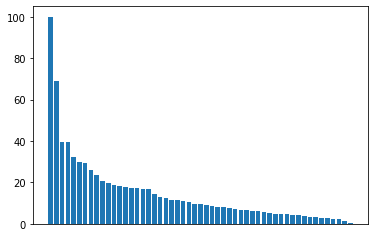

In [10]:
xs = [x for x, y in scores]
ys = [100*int(y)/bestRate for x, y in scores]

plt.bar(xs, ys)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
plt.rcParams["figure.figsize"] = (13,13)
plt.show()

# **Yippee!**

## Conclusion

According to this submetric, Southside Slopes is the "best" neighborhood in Pittsburgh. This metric favors large neighborhoods with low population density, so it makes sense. Personally, I like neighborhoods like Squirrel Hill and Greenfield, which are rated no higher than 8%. This is likely because I prefer neighborhoods with parks and trails, which are not conducive to baseball fields. That being said, I think neighborhoods like Southside Slopes and Polish Hill are still great neighborhoods that are also well-reflected using this metric.